We need a model which allow us to concisely set up inflation parameters at Genesis. By default standard emission module allows setup the following parameters:

- inflation
- inflation rate change
- inflation min
- inflation max
- goal bonded

The simulation problem stems from the fact that at least 3 input parameters is hard to predict in advance:

- Which percent of drop to ethereum and cosmos will be claimed?
- Which percent of THC will be staked for receiving CYB?
- Which percent of CYB will be bonded for consensus?

Moreover, all this 3 ratios are dynamic in time. Depending on our assumptions parameters must be set in order to target inflation somewhat close to Ethereum: In the first 5 years it is wise to dilute 50% of Genesis tending to somewhat 10x dilution in 100 years.

Also as a result we need one simple chart chart showing which stake could have different cohorts of near Genesis participants in the following 100 years. In the white paper I think we need to illustrate it based on our exceptions of ratios with parameter proposals.

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [20]:
import random
import string

In [360]:
from tqdm import tqdm_notebook

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Static parameters

In [ ]:
INFLATION_RATE
INFLATION_RATE_CHANGE
INFLATION_MIN
INFLATION_MAX
GOAL_BONDED

In [4]:
# Dynamic parameters
# Used airdrop percent
# Used THC???
# Tokens bonded

# Current genesis

# Model definitions

1. Balances are changing
2. Dynamic parameters are chaning
3. Bondings are changing
4. Total inflation is changing

In [490]:
def random_string(string_length=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))

In [586]:
class Network():
    # Constants
    blocks_per_year = 1/3 * 60 * 60 * 24 * 365 
    max_inflation = 0.12
    min_inflation = 0.5
    inflation_rate = 0.1
    start_inflation = 0.1
    bonding_goal = 0.9
    
    # Dynamic parameters
    block = -1
    transactions_reward = 0
    inflation = start_inflation
    total_bonding = 0
    total_balance = 0
    
    def _create_validators(self):
        self.validators = []
        # TODO increase validators per year
        for i in range(self.validators_amount):
            validator = Validator(self)
            self.validators.append(validator)
    
    def _create_agents(self):
        self.agents = []
        for i in range(self.agents_amount):
            agent = Agent(self)
            self.agents.append(agent)
    
    def __init__(self, validators_amount, agents_amount):
        self.validators_amount = validators_amount
        self.agents_amount = agents_amount
        self._create_validators()
        self._create_agents()
        
    def _change_inflation(self):
        if (self.block == 0) or (self.block % self.blocks_per_year != 0):
            return
        
        current_bonding_rate = self.total_bonding / self.total_balance

        if (self.bonding_goal < current_bonding_rate):
            self.inflation -= self.inflation_rate
        else:
            self.inflation += self.inflation_rate
        self.inflation = max(self.min_inflation, min(self.max_inflation, self.inflation))
    
    def _increase_block(self):
        self.block += 1
        self._change_inflation()
        self.transactions_reward = 0
        self.block_reward = self.inflation * self.total_balance / self.blocks_per_year
        
    def _act_validators(self):
        self.total_balance += self.block_reward
        for validator in tqdm_notebook(self.validators):
            validator.act()
            
    def _act_agents(self):
        for agent in tqdm_notebook(self.agents):
            agent.act()
            
    def act(self):
        self._increase_block()
        self._act_agents()
        self._act_validators()
    
    # TODO These methods should be moved to proper locations

    def get_random_agent(self):
        return np.random.choice(self.agents)
    
    def get_random_validator(self):
        return np.random.choice(self.validators)
    
    def send_transaction(self, sender, receiver, amount, comission):
        assert sender.balance >= amount + comission
        sender.balance -= amount + comission
        receiver.balance += amount
        self.transactions_reward += comission
        
    def bond_validator(self, agent, validator, new_stake):
        old_stake = validator.bonding.get(agent, 0)
        difference = new_stake - old_stake
        assert agent.balance >= difference
        agent.balance -= difference
        validator.bonding[agent] = new_stake
        validator.total_bonding += difference
        self.total_bonding += difference
        
    def get_voting_power(self, validator):
        # TODO add cache for voting power
        return validator.total_bonding / self.total_bonding
    
    def claim_tokens(self, agent, amount):
        assert agent.genesis_part >= amount
        agent.balance += amount
        agent.genesis_part -= amount
        
    def send_reward(self, validator, agent, rate):
        agent.balance += validator.reward * rate

In [544]:
class NetworkParticipant():
    network = None
    id = None
    
    def __init__(self, network):
        self.network = network
        self.id = random_string()

Agent:
- Genesis state
- Balance (total, bonded)
- Transaction probability
- Bonded validators
- Sended transactions

Each block for agent
1. Claim the rest of tokens
2. Do random transactions 
3. Get reward from validators 
4. Rebond tokens

In [563]:
# TODO add agent groups with different claim strategy
class Agent(NetworkParticipant):
    # Constants
    max_comission_rate = 0.1
    claim_probability = 0.01
    transaction_probability = 0.9
    rebond_probability = 0.1
    
    # Dynamic parameters
    genesis_part = 0
    balance = 0
    
    def __init__(self, network, genesis_part=100):
        super().__init__(network)
        self.genesis_part = genesis_part
        
    def _claim(self):
        if np.random.rand() > self.claim_probability:
            return
        
        amount = np.random.rand() * self.genesis_part
        self.network.claim_tokens(self, amount)
    
    def _do_random_transaction(self):
        if np.random.rand() > self.transaction_probability:
            return
        
        receiver = self
        while receiver == self:
            receiver = self.network.get_random_agent()
        total_amount = np.random.rand() * self.balance
        comission = np.random.rand() * self.max_comission_rate * total_amount
        amount = total_amount - comission
        self.network.send_transaction(self, receiver, amount, comission)
        
    def _rebond_tokens(self):
        if np.random.rand() > self.rebond_probability:
            return
        
        validator = self.network.get_random_validator()
        amount = np.random.rand() * self.balance
        self.network.bond_validator(self, validator, amount)
    
    def act(self):
        self._claim()
        self._do_random_transaction()
        self._rebond_tokens()

Validator:
- Comission
- Voting power
- Slowness probability
- Double-spend probability

Each block for validator:
1. Create
2. Update comission
3. Gather all transactions reward
4. Receive block reward depending on voting power
5. Do random event (nothing, double-spend, slowness)

In [564]:
class Validator(NetworkParticipant):
    # Dynamic parameters
    comission_rate = 0
    total_bonding = 0
    reward = 0
    
    def __init__(self, network):
        super().__init__(network)
        self.bonding = {}
    
    def _update_comission(self):
        self.comission_rate = np.random.rand()
        
    def _receive_reward(self):
        voting_power = self.network.get_voting_power(self)
        self.reward = voting_power * (self.network.block_reward + self.network.transactions_reward)
        # TODO move part of reward to validator's owner
        self.reward = (1 - self.comission_rate) * self.reward
        
    def _broadcast_reward(self):
        for agent, stake in self.bonding.items():
            rate = stake / self.total_bonding
            self.network.send_reward(self, agent, rate)
            
    def act(self):
        self._update_comission()
        self._receive_reward()
        self._broadcast_reward()

# Tests

In [565]:
def assert_catch_exception(test_function, exception_class):
    exception_caught = False
    try:
        test_function()
    except exception_class:
        exception_caught = True
    assert exception_caught

## Network

Network should create validators and agents when created

In [566]:
network = Network(1, 1)

assert len(network.validators) == 1
assert len(network.agents) == 1

Network should send transactions

In [567]:
network = Network(1, 1)

sender = Agent(network)
sender.balance = 100

receiver = Agent(network)
receiver.balance = 10

network.send_transaction(sender, receiver, 10, 10)
assert sender.balance == 100 - 20
assert receiver.balance == 10 + 10
assert network.transactions_reward == 10

network.send_transaction(sender, receiver, 80, 0)
assert_catch_exception(
    lambda: network.send_transaction(sender, receiver, 80, 10),
    AssertionError
)

Network should bond agent stake to validators

In [568]:
network = Network(1, 1)

validator = Validator(network)
assert not validator.bonding

agent = Agent(network)
agent.balance = 100

network.bond_validator(agent, validator, 20)
assert validator.bonding[agent] == 20
assert agent.balance == 100 - 20
assert validator.total_bonding == 20
assert network.total_bonding == 20

network.bond_validator(agent, validator, 10)
assert validator.bonding[agent] == 10
assert agent.balance == 100 - 10
assert validator.total_bonding == 10
assert network.total_bonding == 10

network.bond_validator(agent, validator, 100)
assert_catch_exception(
    lambda: network.bond_validator(agent, validator, 110),
    AssertionError
)

Network should return voting power for each validator

In [569]:
network = Network(1, 1)

validator1 = Validator(network)
validator2 = Validator(network)

agent1 = Agent(network)
agent1.balance = 100

agent2 = Agent(network)
agent2.balance = 100

agent3 = Agent(network)
agent3.balance = 100

network.bond_validator(agent1, validator1, 10)
network.bond_validator(agent2, validator1, 10)
network.bond_validator(agent3, validator2, 10)

# print(network.get_voting_power(validator1))
assert network.get_voting_power(validator1) == 20 / 30
assert network.get_voting_power(validator2) == 10 / 30

Network should send reward from validator to agent

In [570]:
network = Network(1, 1)

validator = Validator(network)
validator.reward = 200

agent = Agent(network)
agent.balance = 10

network.send_reward(validator, agent, 0.1)

assert agent.balance == 10 + 0.1 * 200

Network should increase block

In [571]:
network = Network(1, 1)

network._increase_block()
assert network.block == 0

network._increase_block()
assert network.block == 1

Network should reset transactions reward after increase

In [572]:
network = Network(1, 1)
network.transactions_reward = None

network._increase_block()
assert network.transactions_reward == 0

Network should recount block reward after increase

In [573]:
network = Network(1, 1)
network.inflation = 0.1
network.blocks_per_year = 2
network.total_balance = 100
network.block_reward = None

network._increase_block()
assert network.block_reward == 0.1 * 100 / 2

Network should recount inflation each year depending on total bonding and total balance

In [574]:
network = Network(1, 1)
network.start_inflation = 0.1
network.max_inflation = 0.2
network.min_inflation = 0.0
network.inflation_rate = 0.1
network.blocks_per_year = 2
network.bonding_goal = 0.5

network.total_bonding = 0
network.total_balance = 100

# Initial inflation is equal to start one
network._increase_block()
assert network.inflation == 0.1

# Do not change inflation during a year
network._increase_block()
assert network.inflation == 0.1

# Increase inflation by defined rate when bonding rate is too low
network._increase_block()
assert network.inflation == 0.1 + 0.1

# Do not change inflation more than max
network._increase_block()
network._increase_block()
assert network.inflation == 0.2

network.total_bonding = 55
network.total_balance = 100

# Decrease inflation by defined rate when bonding rate is too low
network._increase_block()
network._increase_block()
network._increase_block()
network._increase_block()
assert network.inflation == 0.2 - 0.1 - 0.1

# Do not change inflation less than min
network._increase_block()
network._increase_block()
assert network.inflation == 0.0

Network should return random agent

In [575]:
network = Network(1, 2)
assert network.get_random_agent() in network.agents

Network should return random validator

In [576]:
network = Network(2, 1)
assert network.get_random_validator() in network.validators

Network should claim agent tokens

In [577]:
network = Network(1, 1)
agent = Agent(network)
agent.genesis_part = 10

network.claim_tokens(agent, 5)
assert agent.genesis_part == 5
assert agent.balance == 5

assert_catch_exception(
    lambda: network.claim_tokens(agent, 6),
    AssertionError
)

## Agent

Agent should send nonzero random transaction to another agent

In [578]:
network = Network(1, 2)
agent = network.agents[0]

agent.transaction_probability = 1
agent.balance = 100
old_balance = agent.balance

agent._do_random_transaction()
    
assert agent.balance < 100
assert network.agents[1].balance > 0

Agent should rebond tokens randomly

In [579]:
network = Network(1, 1)
agent = network.agents[0]
validator = network.validators[0]

agent.rebond_probability = 1
agent.balance = 100
old_balance = agent.balance

agent._rebond_tokens()
    
assert agent.balance < 100
assert validator.bonding[agent] > 0

Agent should claim tokens

In [580]:
network = Network(1, 1)
agent = network.agents[0]
assert agent.balance == 0

agent.claim_probability = 1
agent.genesis_part = 100

agent._claim()
    
assert agent.balance > 0
assert agent.genesis_part < 100

## Validator

Validator should update comission

In [581]:
network = Network(1, 1)
validator = network.validators[0]

old_comission_rate = validator.comission_rate

validator._update_comission()
assert validator.comission_rate != old_comission_rate

Validator should receive reward

In [582]:
network = Network(1, 1)
validator = network.validators[0]
network.get_voting_power = lambda x: 0.1
network.block_reward = 100
network.transactions_reward = 200
validator.comission_rate = 0.1

validator._receive_reward()
assert round(validator.reward) == round((1 - 0.1) * 0.1 * (100 + 200))

Validator should send reward to all bonded agents depending on their rates

In [583]:
network = Network(1, 2)
validator = network.validators[0]
agent1 = network.agents[0]
agent2 = network.agents[1]

agent1.balance = 100
agent2.balance = 100

network.bond_validator(agent1, validator, 1)
network.bond_validator(agent2, validator, 4)

validator.reward = 20

validator._broadcast_reward()
assert agent1.balance == (100 - 1) + 20 * 1 / 5
assert agent2.balance == (100 - 4) + 20 * 4 / 5

# Big network evaluation

In [589]:
network = Network(100, 100)

In [590]:
for i in tqdm_notebook(range(100)):
    network.act()

ZeroDivisionError: float division by zero

# Visualization

In [9]:
# Target value graph
# - For each group - count total balance during some years

In [7]:
# Requirements
# 50% of genesis are diluted in 5 years
# 10x of genesis are diluted in 100 years

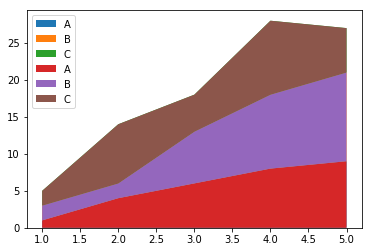

In [8]:
# library
import numpy as np
import matplotlib.pyplot as plt
 
# --- FORMAT 1
 
# Your x and y axis
x=range(1,6)
y=[ [1,4,6,8,9], [2,2,7,10,12], [2,8,5,10,6] ]
 
# Basic stacked area chart.
plt.stackplot(x,y, labels=['A','B','C'])
plt.legend(loc='upper left')
#plt.show()
 
# --- FORMAT 2</pre>
x=range(1,6)
y1=[1,4,6,8,9]
y2=[2,2,7,10,12]
y3=[2,8,5,10,6]
 
# Basic stacked area chart.
plt.stackplot(x,y1, y2, y3, labels=['A','B','C'])
plt.legend(loc='upper left')